### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Apr 3rd at 11.59pm CST
---

## Problem 1

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

##### 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# reading in data
data = np.load('../../homeworks/hw_data/hw6_data_1.npy')

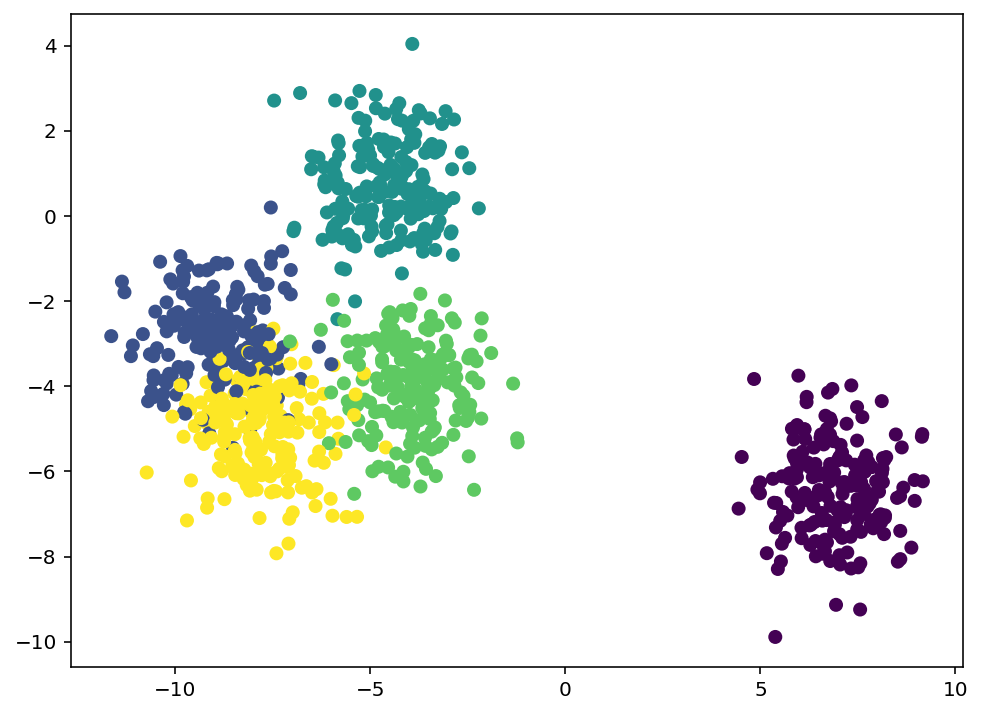

In [3]:
# plotting data
plt.figure(figsize=(8,6))
plt.scatter(data[:,0], data[:,1], c=data[:,2]);

##### 2.

In [4]:
# importing required sklearn modules
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

K = 5 # number of cross-correlations
bwrange = np.linspace(0.1, 1.0, 30) # range of bandwidths to test

# test each bandwidth with K folds
grid = GridSearchCV(KernelDensity(), {'bandwidth':bwrange}, cv=K)

# fit the data and find best bandwidth
grid.fit(data)
h_opt = grid.best_params_['bandwidth']

print(f'Best bandwidth = {h_opt}')

Best bandwidth = 0.19310344827586207


<ipython-input-5-5a96e575f095>:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u,v))).T


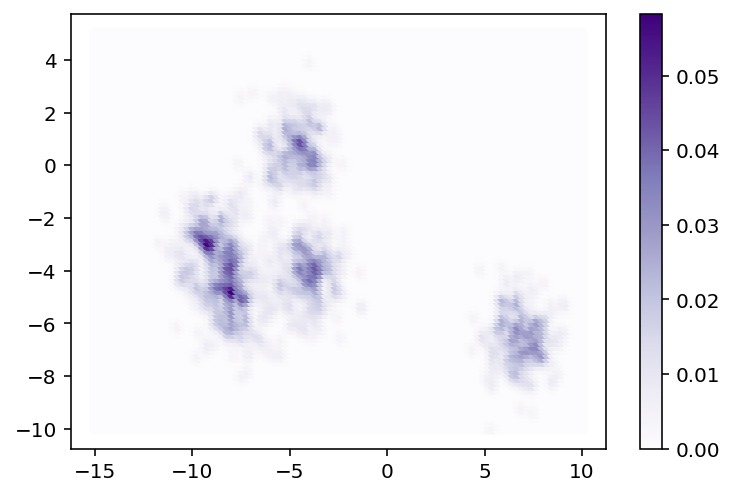

In [5]:
# fitting data usign kde with optimal bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(data[:,:2])

# set-up 2d histogram
D = 100
u = np.linspace(-15, 10, D)
v = np.linspace(-10, 5, D)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u,v))).T

# evaluate kde on grid
dens_kde = np.exp(kde.score_samples(Xgrid))

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_kde, 
            cmap="Purples", edgecolor="None")
plt.colorbar();

##### 3.

In [6]:
# import required modules
from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist

In [7]:
x = data[:,:2]

# using kNN on the data
k = 30 # number of nearest neighbours used
kNN = KNeighborsDensity('bayesian', n_neighbors=k)
kNN.fit(x)
dens_knn = kNN.eval(Xgrid) / data.shape[0]

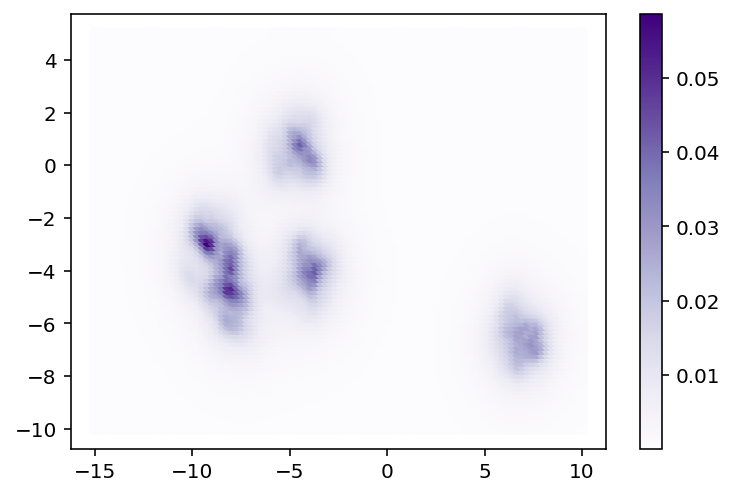

In [8]:
# overplotting data onto KDE results
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_knn, 
            cmap="Purples", edgecolor="None")
plt.colorbar();

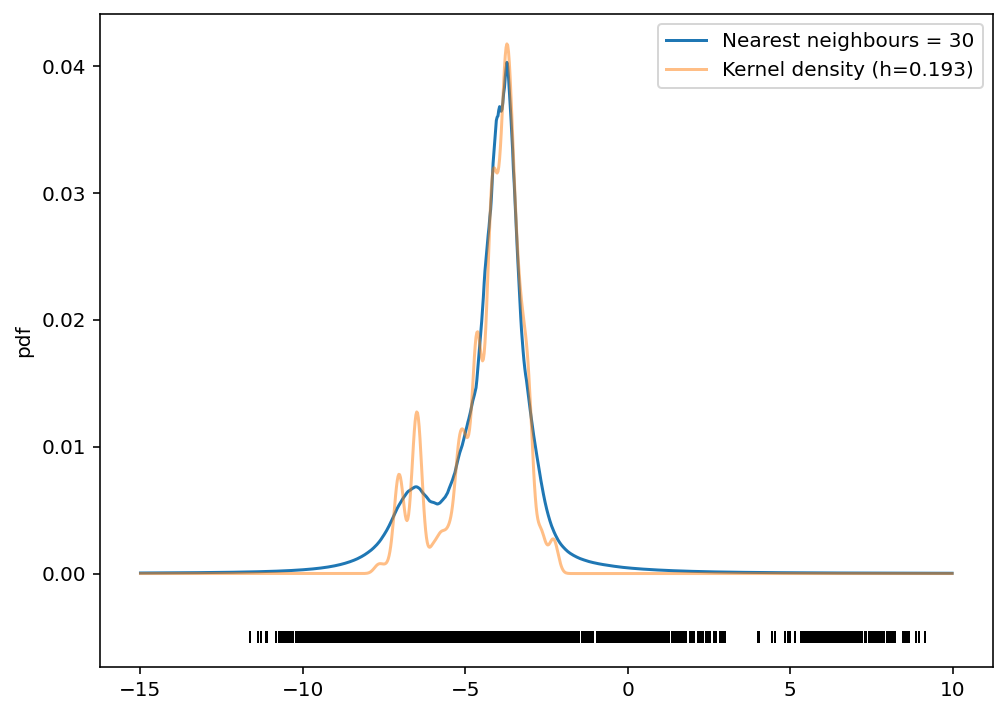

In [9]:
# running kde on one dimension of sample
t = np.linspace(-15., 10., 2000).reshape(-1,2)
kde1d = KernelDensity(bandwidth=h_opt, kernel='gaussian')
kde1d.fit(data[:,:2])
dens_kde = np.exp(kde1d.score_samples(t))

dens_knn1d = kNN.eval(t) / data.shape[0]

plt.figure(figsize=(8,6))
plt.plot(data, -0.005 * np.ones(len(data)), '|k')
plt.plot(t[:,0], dens_knn1d, '-', lw=1.5, color='C0', 
         zorder=2, label=f'Nearest neighbours = {k}')
plt.plot(t[:,0], dens_kde, '-', color='C1', alpha=0.5, 
         zorder=3, label=f'Kernel density (h={h_opt:.3f})')
plt.ylabel('pdf')
plt.legend();

Number of nearest neighbours used k = 30

##### 4.

In [10]:
# import required modules
from sklearn.mixture import GaussianMixture

In [11]:
# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

models = [GaussianMixture(N[i]).fit(data[:,:2]) for i in range(len(N))]

# computing the AIC and the BIC
AIC = [m.aic(data[:,:2]) for m in models]
BIC = [m.bic(data[:,:2]) for m in models]

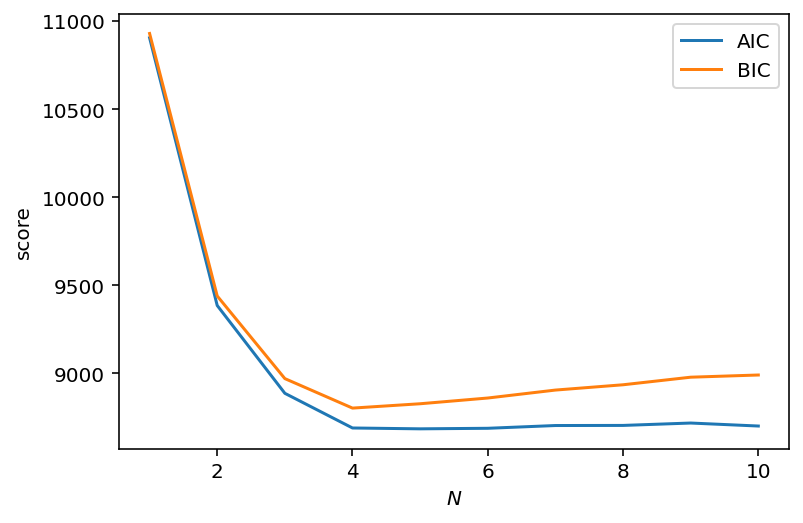

In [12]:
# plotting aic and bic as function of components
plt.plot(N, AIC, label='AIC')
plt.plot(N, BIC, label='BIC')
plt.xlabel(r'$N$')
plt.ylabel('score')
plt.legend();

The AIC levels off at $N=4$, however the BIC reaches a minimum at $N=4$. The optimum number of components in $N=4$

In [13]:
# Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, sigmas=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 
                   + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for sigma in sigmas:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * sigma * sigma1, 2 * sigma * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

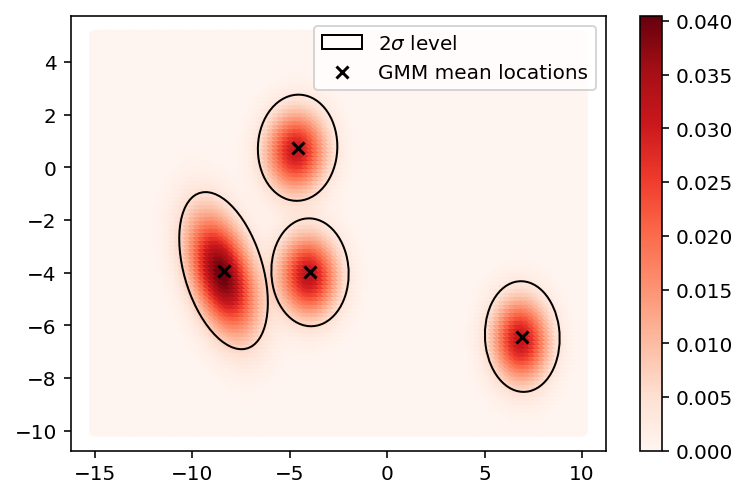

In [14]:
gmm = GaussianMixture(4).fit(data[:,:2])
dens_gmm = np.exp(gmm.score_samples(Xgrid))

fig, ax = plt.subplots()
cs = ax.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_gmm, 
            cmap="Reds", edgecolor="None")
fig.colorbar(cs);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], c='k',
            marker='x', label='GMM mean locations')
draw_ellipse(gmm.means_[0], gmm.covariances_[0], sigmas=[2], fill=None)
draw_ellipse(gmm.means_[1], gmm.covariances_[1], sigmas=[2], fill=None)
draw_ellipse(gmm.means_[2], gmm.covariances_[2], sigmas=[2], fill=None)
draw_ellipse(gmm.means_[3], gmm.covariances_[3], sigmas=[2], fill=None,
             label=r'$2\sigma$ level')
ax.legend();

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

In [15]:
# import Kmeans module
from sklearn.cluster import KMeans
from sklearn import preprocessing

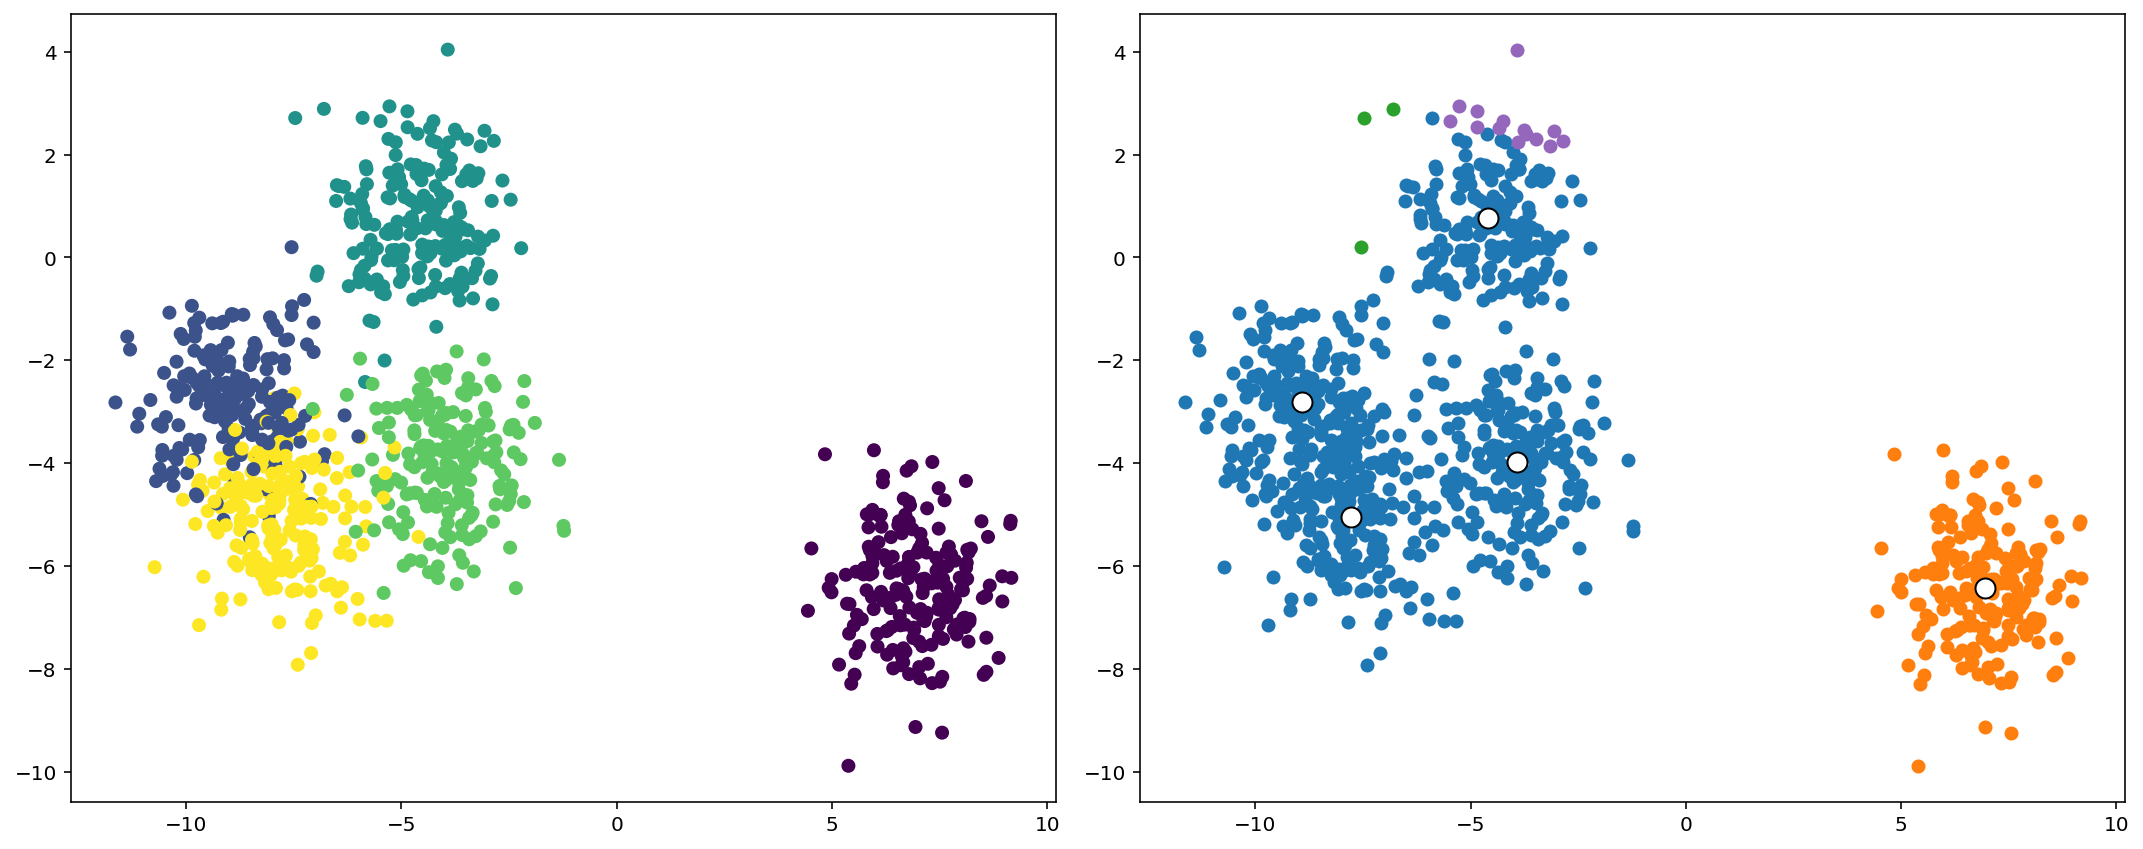

In [21]:
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters=5)
clf.fit(scaler.fit_transform(data))

centers = clf.cluster_centers_ #location of the clusters
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
labels = clf.predict(data) #labels for each of the points

# plot the data color-coded by cluster id
fig, axs = plt.subplots(ncols=2, figsize=(15,6), tight_layout=True)

ax = axs[0]
ax.scatter(data[:,0], data[:,1], c=data[:,2]);

ax = axs[1]
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
for ii in range(5):
    ax.scatter(data[labels==ii,0], data[labels==ii,1],
                color=colors[ii])
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
       s=100, c='w', edgecolors='k');

---

## Problem 2

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data. 

1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.

In [22]:
from astroML.datasets import fetch_imaging_sample
data = fetch_imaging_sample()  
data.shape  # number of objects in dataset

print(data.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X = np.column_stack([data[key] for key in keylist]) 

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to $2$ features. What is the explained variance of the data encapsulated in these eigen-features?


3. Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.


4. Choose $5000$ random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these $5000$ random samples, colored by their corresponding `type`. *(You may want to set the transparency to be lower than 1 to see the mixing of samples.)*


5. Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the $5000$ random samples identified in the previous part. 
    - Try `LocallyLinearEmbedding`, `Isomap`, and `TSNE` algorithms, setting the number of components to be $2$ in all cases. 
    - As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their `type`. For LLE and Isomap, experiment with the number of nearest neighbors between $5$ and $100$ to see what visually gives the best separation in `type` populations. For TSNE, do the same for the perplexity attribute. 
    - Which algorithm gives the cleanest way to visually see the two populations of sources? *(This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)*

### Solution

##### 2.

In [23]:
# import pca module
from sklearn.decomposition import PCA

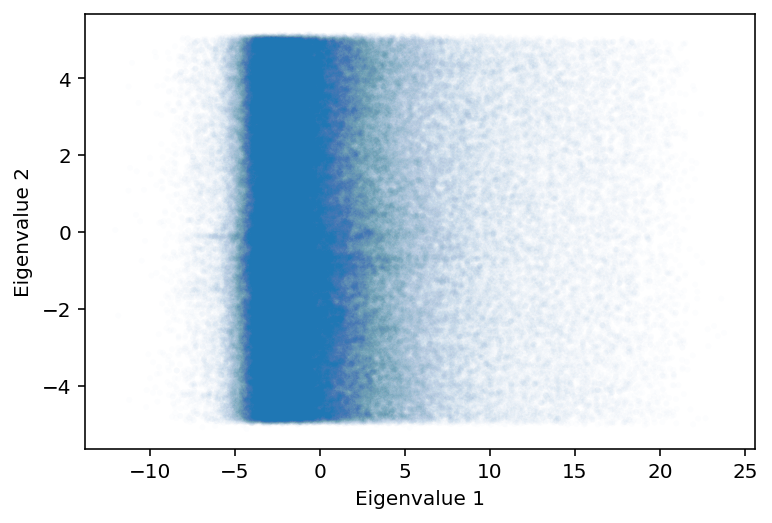

In [24]:
# decompose data to 2 features
pca = PCA(n_components=2)
pca.fit(X)

X_reduced = pca.transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], 
            marker=".", color='C0', 
            alpha=0.01, edgecolors='None')
plt.xlabel('Eigenvalue 1')
plt.ylabel('Eigenvalue 2');

In [25]:
print("The first component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[0]))
print("The second component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[1]))
print("All components explain {:.3f} of the variance in the data.".format(sum(pca.explained_variance_ratio_)))

The first component explains 0.533 of the variance in the data.
The second component explains 0.250 of the variance in the data.
All components explain 0.783 of the variance in the data.


##### 3.

In [26]:
labels = np.array(data['type'])
labels

array([3, 6, 3, ..., 3, 6, 3], dtype=int16)

fetch_imaging_sample() runs a SQL script on the SDSS PhotoTag database (a subset of the PhotoObjAll dataset). The 'type' key refers to the type of object being observed. Each number corresponds to a corresponding type of object, listed below.

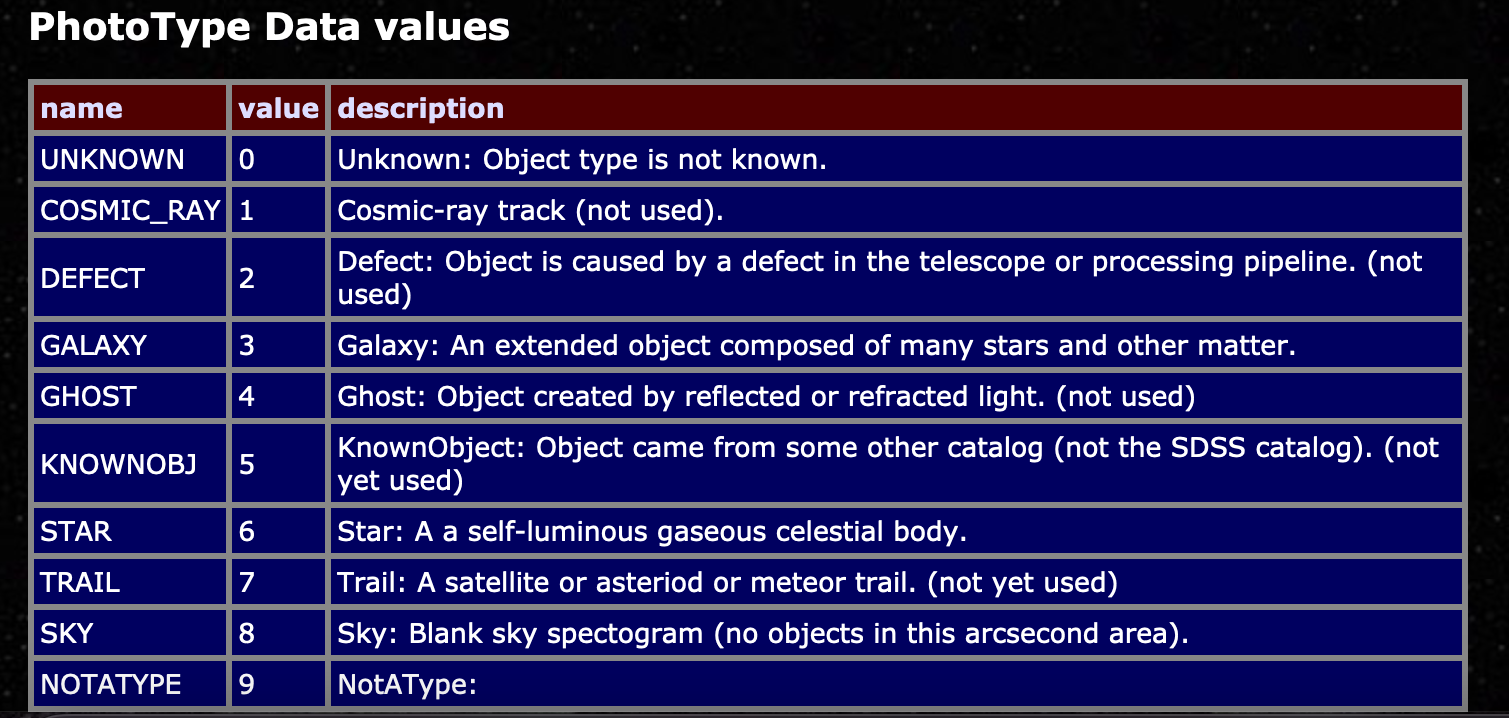

##### 4.

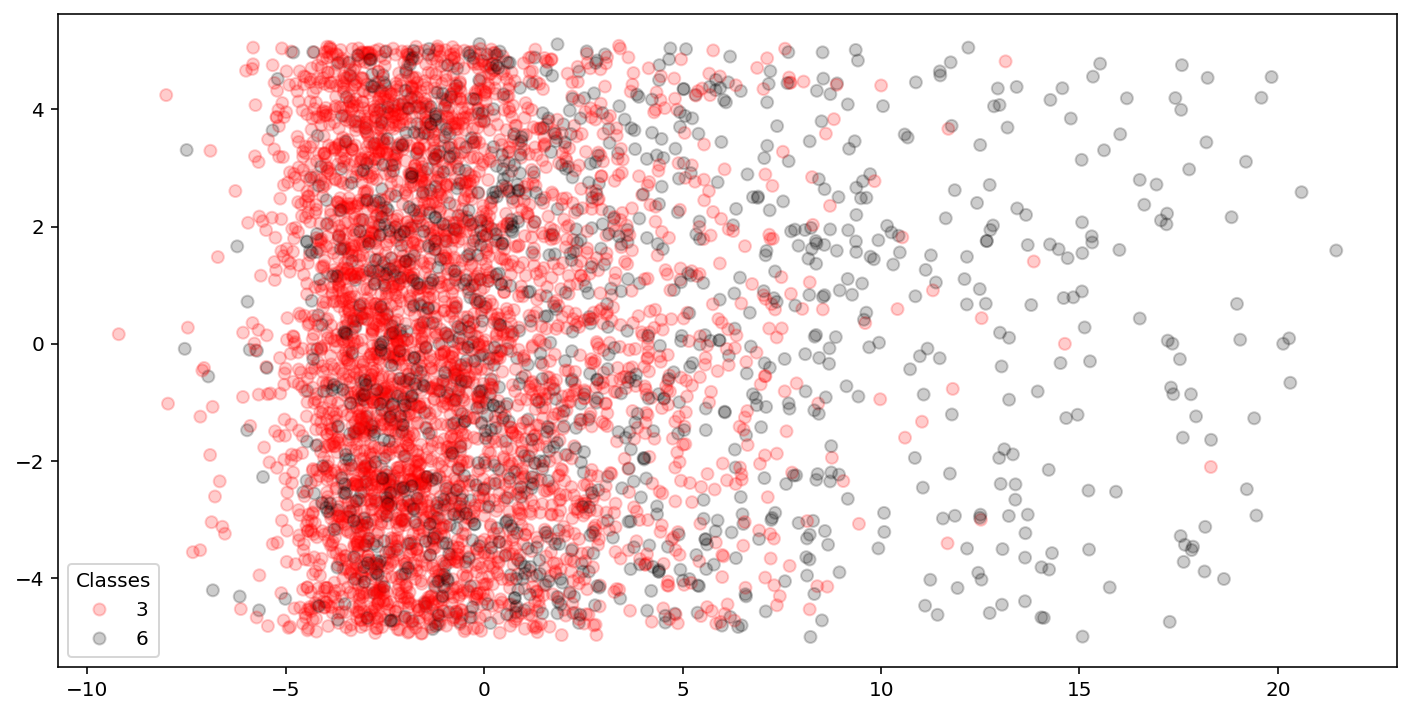

In [40]:
# initialising array of random ints
idx = np.random.randint(0, data.shape[0], 5000)

# plot random 5000 samples, coloured by type
plt.figure(figsize=(12,6))
scatter = plt.scatter(X_reduced[:,0][idx], X_reduced[:,1][idx], c=data['type'][idx],
            cmap='flag', alpha=0.2);
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

##### 5.

In [41]:
# load in required modules
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE

In [47]:
# subset of data to be used
X2 = X[idx]

In [76]:
# locally linear embedding

n = 2 # number of components
k = 30 # number of nearest neighbours

lle = LocallyLinearEmbedding(n_components=n,
                             n_neighbors=k)
lle.fit(X2)
X_lle = lle.transform(X2)

In [81]:
# isomap

n = 2 # number of components
k = 5 # number of nearest neighbours

iso = Isomap(n_neighbors=k,
             n_components=n)
iso.fit(X2)
X_iso = iso.transform(X2)

In [50]:
# TSNE
tsne = TSNE(n_components=n, perplexity=25.)
X_tsne = tsne.fit_transform(X2)

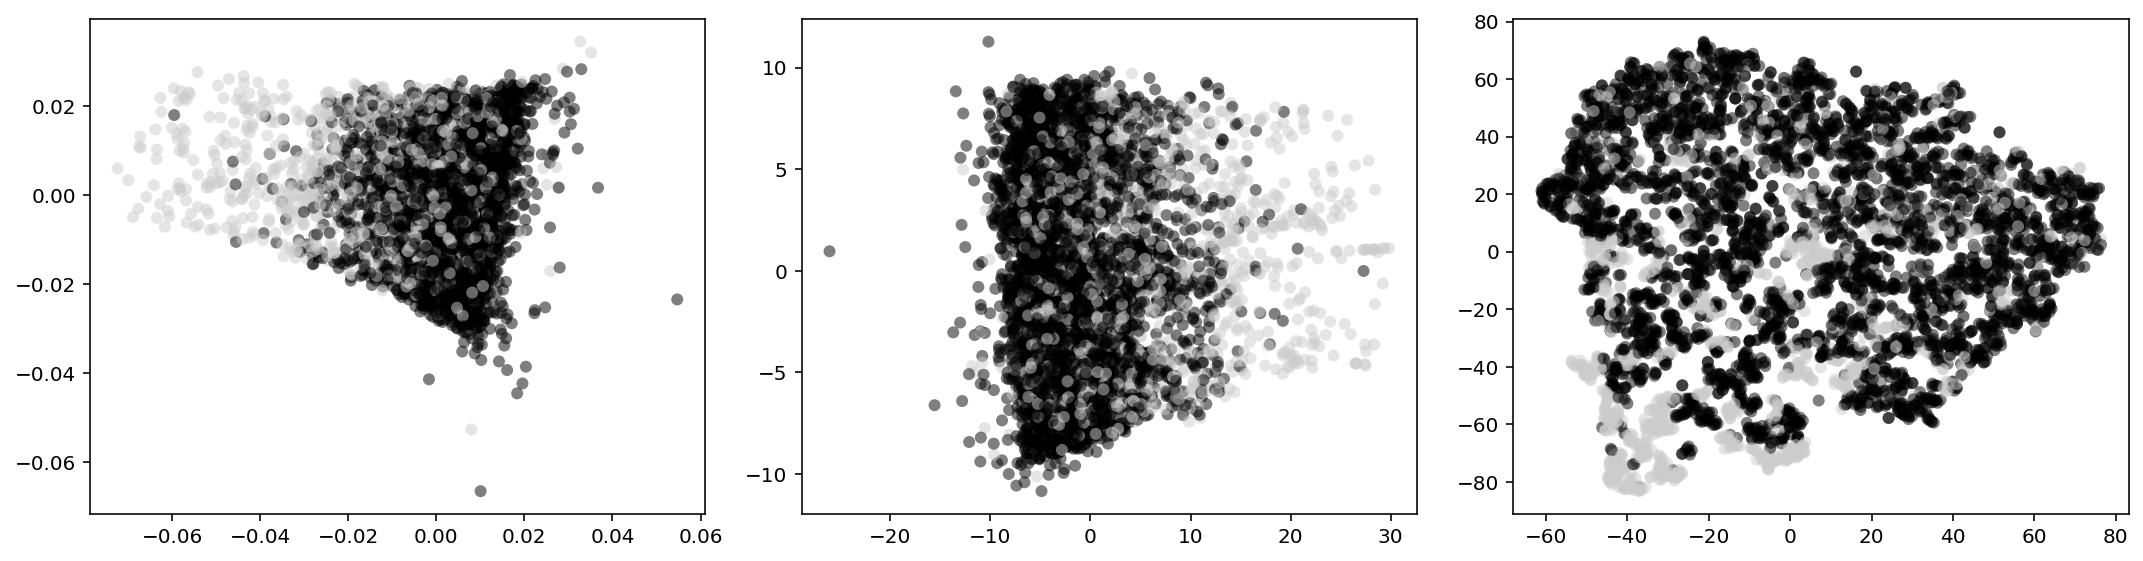

In [82]:
figs, axs = plt.subplots(ncols=3, figsize=(15,4), tight_layout=True)

ax = axs[0]
lle_map = ax.scatter(X_lle[:,0], X_lle[:,1], c=data['type'][idx],
            cmap="nipy_spectral", edgecolor="None", alpha=0.5)
ax = axs[1]
iso_map = ax.scatter(X_iso[:,0], X_iso[:,1], c=data['type'][idx],
            cmap="nipy_spectral", edgecolor="None", alpha=0.5)
ax = axs[2]
tsne_map = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=data['type'][idx],
            cmap="nipy_spectral", edgecolor="None", alpha=0.5)

I find that LLE is the best method to visualise the two groups of data, but it is only marginally better than Isomap. They are both better than TSNE. They are all hard to find the ideal parameters to seperate the two groups of data though